# Ecommerce data에 적용 & flask app의 DB에 삽입할 준비

In [1]:
import pandas as pd
import numpy as np
import io
import scipy.sparse as ss
import json
import time
import datetime
import os

### 0) set configs

In [2]:
data_dir = "../../../data/ecommerce/"

In [3]:
os.listdir(data_dir)

['interaction.csv', 'product_title.csv', 'user.csv']

### 1) Load interaction df

In [4]:
interactions_df=pd.read_csv(data_dir+"interaction.csv")

In [5]:
print(interactions_df.shape)
interactions_df.head()

(176566, 3)


USER_ID       ITEM_ID   TIMESTAMP
0  9006029694274259015-3        A12345  1621566880
1  8812677991523562398-3  GGOEGAAX0031  1617888384
2  8651356451380007464-1  GGOEGAAX0031  1618524758
3  0930973790425942838-1  GGOEGAAX0031  1621120669
4  5017352267517896224-6  GGOEGAAX0031  1621877599

In [6]:
user_id="USER_ID"
item_id="ITEM_ID"

In [7]:
# long tail
interactions_df.USER_ID.value_counts()[interactions_df.USER_ID.value_counts()>1]

741993131378886687-24    162
7963396423050396529-1    111
153855991963063276-1     105
7558132299181088801-1    105
3560900121641699481-1    103
                        ... 
1639362549007376369-3      2
5350614863718774110-1      2
4807811175920572667-1      2
5579963663237944825-1      2
2388326140749356101-1      2
Name: USER_ID, Length: 33632, dtype: int64

<AxesSubplot:>

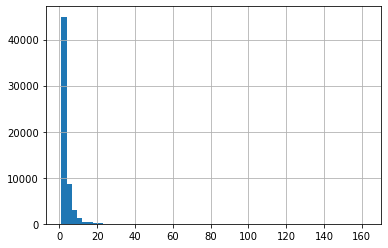

In [8]:
# histogram
interactions_df.USER_ID.value_counts().hist(bins=58)

### 2) filter out users with few interactions

In [9]:
# 오직 1건의 인터렉션만을 갖는 유저를 배제 

available_user_list=interactions_df.USER_ID.value_counts()[interactions_df.USER_ID.value_counts()>1].index.tolist()

available_user_interactions=interactions_df[interactions_df.USER_ID.isin(available_user_list)]

In [10]:
available_user_interactions=available_user_interactions.reset_index(drop=True)

In [11]:
item_dict=dict(zip(available_user_interactions.ITEM_ID.unique(),range(len(available_user_interactions.ITEM_ID.unique()))))

user_dict=dict(zip(available_user_interactions.USER_ID.unique(),range(len(available_user_interactions.USER_ID.unique()))))

In [12]:
import joblib

In [13]:
joblib.dump(item_dict, "item_dict.pkl")

['item_dict.pkl']

In [14]:
joblib.dump(user_dict, "user_dict.pkl")

['user_dict.pkl']

In [15]:
item_dict_reverse=dict(zip(range(len(available_user_interactions.ITEM_ID.unique())), available_user_interactions.ITEM_ID.unique()))

user_dict_reverse=dict(zip(range(len(available_user_interactions.USER_ID.unique())), available_user_interactions.USER_ID.unique()))

In [16]:
# test는 20% save를 위해 5건 이상 인터렉션이 있는 유저로부터 ...
test_candidate_ids=available_user_interactions.USER_ID.value_counts()[available_user_interactions.USER_ID.value_counts()>=5].index.tolist()

# test 대상 유저의 수는 전체 가용 인원의 10%
test_user_num=round(len(available_user_list)/10)

In [17]:
import random

test_user_ids=random.sample(test_candidate_ids, test_user_num)

In [18]:
train_user_ids=list(set(available_user_list)-set(test_user_ids))

In [19]:
print(len(train_user_ids))
print(len(test_user_ids))

30269
3363


In [20]:
train_df=available_user_interactions[available_user_interactions.USER_ID.isin(train_user_ids)]
test_df=available_user_interactions[available_user_interactions.USER_ID.isin(test_user_ids)]

In [21]:
test_df_for_test=test_df.groupby("USER_ID").apply(lambda x: x.sample(frac=0.2))

test_df_for_test=test_df_for_test.drop("USER_ID",axis=1).reset_index()

test_df_for_test=test_df_for_test.set_index("level_1")

test_df_for_train=test_df[~(test_df.index.isin(test_df_for_test.index))]

In [22]:
total_train_df=pd.concat([train_df, test_df_for_train])

In [23]:
total_train_df["ITEM_IDX"]=total_train_df['ITEM_ID'].map(item_dict)

total_train_df["USER_IDX"]=total_train_df['USER_ID'].map(user_dict)

In [24]:
test_df_for_test["ITEM_IDX"]=test_df_for_test['ITEM_ID'].map(item_dict)

test_df_for_test["USER_IDX"]=test_df_for_test['USER_ID'].map(user_dict)

In [25]:
# collaborative filtering implementation
# https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

In [26]:
n_users=available_user_interactions.USER_ID.nunique()

In [27]:
n_items=available_user_interactions.ITEM_ID.nunique()

In [28]:
interaction_matrix = np.zeros((n_users, n_items))

for row in total_train_df.itertuples():
    interaction_matrix[row[-1], row[-2]] = 1 # row[-4]
    

In [29]:
test_interaction_matrix=np.zeros((n_users, n_items))

for row in test_df_for_test.itertuples():
    test_interaction_matrix[row[-1], row[-2]] = 1 # row[-4]

In [30]:
interaction_matrix.shape

(33632, 374)

In [31]:
test_interaction_matrix.shape

(33632, 374)

In [32]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        # 행렬 내적으로 한번에 처리
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
        
    # 대각원소의 제곱근 값으로 normalize 
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [33]:
%timeit fast_similarity(interaction_matrix, kind='user')

38.8 s ± 669 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
user_similarity = fast_similarity(interaction_matrix, kind='user')
item_similarity = fast_similarity(interaction_matrix, kind='item')

In [35]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    

%timeit predict_slow_simple(ratings, user_similarity, kind='user')


In [36]:
CF_train_predict=predict_fast_simple(interaction_matrix, user_similarity, kind='user')

In [37]:
CF_train_predict.shape

(33632, 374)

In [38]:
subtract_bought_items=np.where(interaction_matrix==0,0,np.inf)

In [39]:
CF_train_predict=np.subtract(CF_train_predict, subtract_bought_items)

In [136]:
n_users

33632

In [137]:
n_items

374

## convert data

### recommendation result

In [40]:
import time
import datetime

In [41]:
# user id를 추가해야함
# recommender id 별도 표시
# item은 별도의 DB에서 조인 걸어서 가져와야하지 않나? -> 일단은 아이템 명을 그대로 넣어버리자

data=[]

for user_id in range(len(CF_train_predict)):
    user=CF_train_predict[user_id]
    reco=np.argsort(user)[::-1][:10].tolist()
    reco=[item_dict_reverse[item_id] for item_id in reco]
#     time_info=datetime.datetime.fromtimestamp(time.time())
#     reco.append(time_info)
    data.append(reco)

In [42]:
df=pd.DataFrame(data)

df.columns=[f"top{i}" for i in range(1,11)]

df["user_id"]=range(0,n_users)

In [43]:
df["recommender_id"]=6

In [44]:
df["modelType"]="SIMS"

In [45]:
df["platform"]="Digital Lab"

In [46]:
df['top1'].append(df['top2']).reset_index(drop=True)

0        GGOEGFKQ020399
1        GGOEGDHQ014899
2        GGOEGBRJ037299
3        GGOEGBRB013899
4        GGOEGHPA003010
              ...      
67259    GGOEYDHJ019399
67260    GGOEYDHJ019399
67261    GGOEYDHJ019399
67262    GGOEYOCR077399
67263    GGOEYOCR077399
Length: 67264, dtype: object

In [47]:
df_stack=df[[f"top{i}" for i in range(1,11)]].stack().reset_index()

df_stack=df_stack.drop("level_0",axis=1)




user_id_list=[i for i in range(df.shape[0])]*10

user_id_list.sort()



df_stack.level_1=df_stack.level_1.apply(lambda x: x.replace("top",""))

df_stack.level_1=df_stack.level_1.apply(int)



df_stack.columns=["priority", "item_name"]

df_stack["user_id"]=user_id_list



df_stack["recommender_id"]=6

df_stack["modelType"]="SIMS"

df_stack["platform"]="Digital Lab"

In [48]:
catalog=pd.read_csv(data_dir+"/product_title.csv")

In [49]:
catalog_dict=pd.Series(catalog.item_title.values,index=catalog.item_id).to_dict()

In [50]:
df_stack["item_title"]=df_stack.item_name.apply(lambda x: catalog_dict[x])

In [54]:
df_stack=df_stack[["priority","item_name","item_title","user_id","recommender_id","modelType","platform"]]
df_stack.columns=["priority","item_name","item_title","user_id","recommender_id","model_type","platform"]

In [60]:
df["top1"]=df.top1.apply(lambda x: catalog_dict[x])
df["top2"]=df.top2.apply(lambda x: catalog_dict[x])
df["top3"]=df.top3.apply(lambda x: catalog_dict[x])
df["top4"]=df.top4.apply(lambda x: catalog_dict[x])
df["top5"]=df.top5.apply(lambda x: catalog_dict[x])
df["top6"]=df.top6.apply(lambda x: catalog_dict[x])
df["top7"]=df.top7.apply(lambda x: catalog_dict[x])
df["top8"]=df.top8.apply(lambda x: catalog_dict[x])
df["top9"]=df.top9.apply(lambda x: catalog_dict[x])
df["top10"]=df.top10.apply(lambda x: catalog_dict[x])

In [56]:
import sqlalchemy

import sqlite3

uri = '/Users/myeonghaklee/dl_mlops/recommender/notebooks/flask_app/matt/app/reco.db'

creator = lambda: sqlite3.connect(uri, uri=True)

db = sqlalchemy.create_engine('sqlite:////', creator=creator)

In [57]:
df_stack.to_sql(name="cf_reco", if_exists="replace", con=db)

In [63]:
df.to_sql(name="sims_reco", if_exists="replace", con=db)

### user history

In [64]:
available_user_interactions=available_user_interactions.rename({"USER_ID":"user_name"}, axis=1)

In [65]:
available_user_interactions["user_id"]=available_user_interactions.user_name.apply(lambda x: user_dict[x])

In [66]:
available_user_interactions=available_user_interactions.rename({"ITEM_ID":"item_name"}, axis=1)

In [67]:
available_user_interactions["item_id"]=available_user_interactions.item_name.apply(lambda x: item_dict[x])

In [68]:
available_user_interactions.TIMESTAMP=available_user_interactions.TIMESTAMP.apply(datetime.datetime.fromtimestamp)

In [69]:
available_user_interactions=available_user_interactions.rename({"TIMESTAMP":"timestamp"}, axis=1)

In [70]:
available_user_interactions

user_name       item_name           timestamp  user_id  \
0       8812677991523562398-3    GGOEGAAX0031 2021-04-08 22:26:24        0   
1       8651356451380007464-1    GGOEGAAX0031 2021-04-16 07:12:38        1   
2       0930973790425942838-1    GGOEGAAX0031 2021-05-16 08:17:49        2   
3       5017352267517896224-6    GGOEGAAX0031 2021-05-25 02:33:19        3   
4       7711078331457530027-1    GGOEGAAX0031 2021-04-20 12:09:22        4   
...                       ...             ...                 ...      ...   
151070  9620125979377481981-3  GGOEYOLR080599 2021-07-06 01:28:56    21265   
151071  5699124712444432990-1  GGOEYOLR080599 2021-07-14 18:15:00     8286   
151072  0873520573729672168-1  GGOEYOLR080599 2021-06-17 01:19:18     3321   
151073  9536312221228165618-2  GGOEYOLR080599 2021-08-03 05:05:36    33553   
151074  7970033840106604301-1  GGOEYOLR080599 2021-06-30 12:24:39     9873   

        item_id  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
151070      373  
151071      373  
151072      373  
151073      373  
151074      373  

[151075 rows x 5 columns]

In [71]:
available_user_interactions["item_title"]=available_user_interactions.item_name.apply(lambda x: catalog_dict[x])

In [73]:
available_user_interactions=available_user_interactions[["user_id","user_name","item_id","item_name","item_title","timestamp"]]

In [74]:
available_user_interactions

user_id              user_name  item_id       item_name  \
0             0  8812677991523562398-3        0    GGOEGAAX0031   
1             1  8651356451380007464-1        0    GGOEGAAX0031   
2             2  0930973790425942838-1        0    GGOEGAAX0031   
3             3  5017352267517896224-6        0    GGOEGAAX0031   
4             4  7711078331457530027-1        0    GGOEGAAX0031   
...         ...                    ...      ...             ...   
151070    21265  9620125979377481981-3      373  GGOEYOLR080599   
151071     8286  5699124712444432990-1      373  GGOEYOLR080599   
151072     3321  0873520573729672168-1      373  GGOEYOLR080599   
151073    33553  9536312221228165618-2      373  GGOEYOLR080599   
151074     9873  7970033840106604301-1      373  GGOEYOLR080599   

                          item_title           timestamp  
0             Google Stretch Fit Hat 2021-04-08 22:26:24  
1             Google Stretch Fit Hat 2021-04-16 07:12:38  
2             Google Stretch Fit Hat 2021-05-16 08:17:49  
3             Google Stretch Fit Hat 2021-05-25 02:33:19  
4             Google Stretch Fit Hat 2021-04-20 12:09:22  
...                              ...                 ...  
151070  YouTube Notebook and Pen Set 2021-07-06 01:28:56  
151071  YouTube Notebook and Pen Set 2021-07-14 18:15:00  
151072  YouTube Notebook and Pen Set 2021-06-17 01:19:18  
151073  YouTube Notebook and Pen Set 2021-08-03 05:05:36  
151074  YouTube Notebook and Pen Set 2021-06-30 12:24:39  

[151075 rows x 6 columns]

In [76]:
available_user_interactions.to_sql(name="user_history", if_exists="replace", con=db)

### DB connection

In [75]:
import sqlalchemy

import sqlite3

uri = '/Users/myeonghaklee/dl_mlops/recommender/notebooks/flask_app/matt/app/reco.db'

creator = lambda: sqlite3.connect(uri, uri=True)

db = sqlalchemy.create_engine('sqlite:////', creator=creator)

In [199]:
# import pickle 
# # pickle.dump(df, open("sims_reco.pkl","wb"))
# df=pickle.load(open("sims_reco.pkl","rb"))

In [269]:
df_stack.to_sql(name="sims_reco", if_exists="replace", con=db)

In [47]:
available_user_interactions.to_sql(name="user_history", if_exists="replace", con=db)

In [243]:
db.execute("SELECT * FROM sqlite_master").fetchall()

[('table', 'alembic_version', 'alembic_version', 2, 'CREATE TABLE alembic_version (\n\tversion_num VARCHAR(32) NOT NULL, \n\tCONSTRAINT alembic_version_pkc PRIMARY KEY (version_num)\n)'),
 ('index', 'sqlite_autoindex_alembic_version_1', 'alembic_version', 3, None),
 ('table', 'putrecommend', 'putrecommend', 8, 'CREATE TABLE putrecommend (\n\tid INTEGER NOT NULL, \n\trecommend_id INTEGER, \n\titem VARCHAR(200) NOT NULL, \n\t"eventTime" DATETIME NOT NULL, \n\tPRIMARY KEY (id), \n\tFOREIGN KEY(recommend_id) REFERENCES getrecommend (id) ON DELETE CASCADE\n)'),
 ('table', 'useritemmodel', 'useritemmodel', 5, 'CREATE TABLE useritemmodel (\n\tid INTEGER NOT NULL, \n\tuser_id VARCHAR(150) NOT NULL, \n\titem_id VARCHAR(200) NOT NULL, \n\tmodel_a VARCHAR(120) NOT NULL, \n\tmodel_b VARCHAR(120) NOT NULL, \n\tmodel_c VARCHAR(120) NOT NULL, \n\tPRIMARY KEY (id), \n\tUNIQUE (user_id)\n)'),
 ('index', 'sqlite_autoindex_useritemmodel_1', 'useritemmodel', 9, None),
 ('table', 'getrecommender', 'getreco

In [87]:
reco

[300, 299, 3, 253, 6, 350, 304, 310, 7, 248]

In [58]:
test_index=[]
for user_name in test_user_ids:
    test_index.append(user_dict[user_name])

In [59]:
test_index=sorted(test_index)

In [60]:
test_user_similarity=CF_train_predict[test_index,:]

In [61]:
test_user_groundtruth=test_interaction_matrix[test_index,:]

In [62]:
test_user_similarity.shape

(3363, 374)

In [ ]:
# 내가 원하는 것 -> 입력으로 들어간 거 메져할 때 배제
# 예측 결과(CF_train_predict)에서 입력으로 들어갔던 아이템과의 인터렉션을 -inf로 만들어주기 -> CF_train_predict에서 train interaction 제거하기
# 

# evaluate

In [65]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import sys
import scipy
import bottleneck as bn
import math
import os

def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=10):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]

    # bn.argpartition
    # kth 번째까지 등장하는 원소들이 리스트 내부에서 가장 작은 kth번째 원소들이도록 partition해주는 인덱스 리스트를 출력해줌.
    # 여기서는 -를 취해줬으므로, k번째까지 등장하는 원소들이 리스트 내부에서 가장 큰 100번째 원소들이도록 partition해주는 인덱스 리스트를 출력.

    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)

    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],idx_topk_part[:, :k]]

    # np.argsort -> sorting한 리스트의 arg를 뱉어냄. 
    # -를 붙여줌으로써 내림차순으로 정리(높은 놈이 위에)
    idx_part = np.argsort(-topk_part, axis=1)

    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted

    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG_filter=(heldout_batch[np.arange(batch_users)[:, np.newaxis],idx_topk]>0)

    DCG = (DCG_filter * tp).sum(axis=1)


    # sparse matrix 내에서, 고객의 총 interaction 수와 k 중 더 작은 것을 골라서 IDCG 계산
    IDCG = np.array([(tp[:min(len(n.nonzero()[0]), k)]).sum() for n in heldout_batch])
    return DCG / IDCG


# In[2]:


def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0)
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

In [66]:
Recall_at_k_batch(test_user_similarity, test_user_groundtruth, 10).mean()

0.21529836833137456

In [67]:
NDCG_binary_at_k_batch(test_user_similarity, test_user_groundtruth, 10).mean()

0.14020717370633137

# 결과 살펴보기

In [68]:
idx_number=15

In [69]:
sample_groundtruth=test_user_groundtruth[idx_number]

# filter out reviews with less than 5 point
sample_groundtruth=np.where(sample_groundtruth>=5,sample_groundtruth,0)

groundtruth_len=sample_groundtruth.nonzero()[0].shape[0]

groundtruth_sorted_index=np.argsort(sample_groundtruth)[::-1][:groundtruth_len]

groundtruth=[]
for review in groundtruth_sorted_index:
    groundtruth.append(item_dict_reverse[review])

In [70]:
groundtruth

[]

In [71]:
sample_recomms=test_user_similarity[idx_number]
recomms_sorted_index=np.argsort(sample_recomms)[::-1][:25]

recomms=[]
for rec in recomms_sorted_index:
    recomms.append(item_dict_reverse[rec])

In [72]:
recomms

['GGOEGFKQ020399',
 'GGOEGAAX0037',
 'GGOEGCMB020932',
 'GGOEGBRJ037299',
 'GGOEGBFC018799',
 'GGOEGHPB071610',
 'GGOEGBRA037499',
 'GGOEGBRJ037399',
 'GGOEGEVA022399',
 'GGOEYFKQ020699',
 'GGOEGCNB021099',
 'GGOEGEFQ071399',
 'GGOEGETR014599',
 'GGOEGODR017799',
 'GGOEGAAX0104',
 'GGOEGBRB013899',
 'GGOEGOXQ016399',
 'GGOEGDHQ015399',
 'GGOEGAAX0105',
 'GGOEGDWC020199',
 'GGOEGBMC056599',
 'GGOEGAAX0358',
 'GGOEGBMJ013399',
 'GGOEGBJL013999',
 'GGOEGOCB017499']